# Model Training
Use this notebook to train a Mask R-CNN model. It can be initialised with pre-trained weights from the COCO dataset to allow for transfer learning as well. Weights will be saved at each epoch as a checkpoint.

Import the required libraries for loading the Mask R-CNN model and pruning it.


In [ ]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob
from skimage.morphology import label
from skimage.io import imread
from skimage.io import imshow
import time
import tensorflow as tf
tf.get_logger().setLevel("ERROR")
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [ ]:
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Due to memory limitations, limit the memory that can be used on the GPU

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4500)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [ ]:
ROOT_DIR = os.path.abspath("") # Setthe root directory of the project, where the notebook is running
DATA_DIR = os.path.join(ROOT_DIR, "datasets/airbus_data") # Set the location of the data
SHIP_CLASS_NAME = 'ship' # Declare the class name to be detected

# Set locations for training and testing data
TRAIN_DATA_DIR = os.path.join(DATA_DIR, "train_v2")
TEST_DATA_DIR = os.path.join(DATA_DIR, "test_v2")
TRAIN_SHIP_SEGMENTATIONS_PATH = os.path.join(DATA_DIR, 'train_ship_segmentations_v2.csv')

Import the Mask R-CNN framework obtained from https://github.com/akTwelve/Mask_RCNN

In [ ]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [ ]:
masks = pd.read_csv(TRAIN_SHIP_SEGMENTATIONS_PATH)

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

Define functions needed to produce the mask outputs

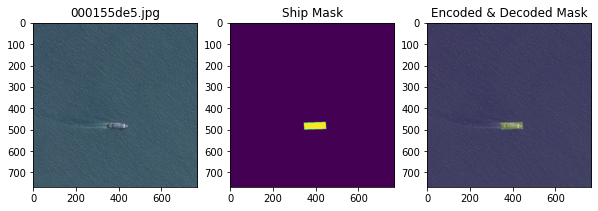

000155de5.jpg  Check Decoding->Encoding RLE_0: 1 -> RLE_1: 1


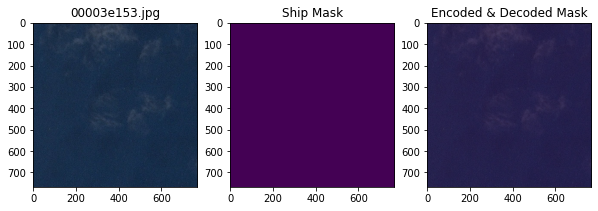

00003e153.jpg  Check Decoding->Encoding RLE_0: 1 -> RLE_1: 0
It could be different when there is no mask.


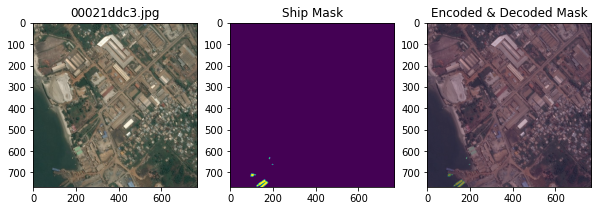

00021ddc3.jpg  Check Decoding->Encoding RLE_0: 9 -> RLE_1: 4
It could be different when there are masks overlapped.


In [ ]:
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

def rle_encode(img):
  
    pixels = img.T.flatten() 
  
    pixels = np.concatenate([[0], pixels, [0]])
 
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
  
    runs[1::2] -= runs[::2]
   
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768,768)):

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def masks_as_image(in_mask_list, shape=(768,768)):
    all_masks = np.zeros(shape, dtype = np.int16)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

def shows_decode_encode(image_id, path=TRAIN_DATA_DIR):
   
    fig, axarr = plt.subplots(1, 3, figsize = (10, 5))
    img_0 = imread(os.path.join(path, image_id))
    axarr[0].imshow(img_0)
    axarr[0].set_title(image_id)
    rle_1 = masks.query('ImageId=="{}"'.format(image_id))['EncodedPixels']
    img_1 = masks_as_image(rle_1)
    axarr[1].imshow(img_1[:, :, 0])
    axarr[1].set_title('Ship Mask')
    rle_2 = multi_rle_encode(img_1)
    img_2 = masks_as_image(rle_2)
    axarr[2].imshow(img_0)
    axarr[2].imshow(img_2[:, :, 0], alpha=0.3)
    axarr[2].set_title('Encoded & Decoded Mask')
    plt.show()
    print(image_id , ' Check Decoding->Encoding',
          'RLE_0:', len(rle_1), '->',
          'RLE_1:', len(rle_2))

shows_decode_encode('000155de5.jpg')
shows_decode_encode('00003e153.jpg')
shows_decode_encode('00021ddc3.jpg')

Create a split for the validation data and exclude some corrupted images


In [ ]:
from PIL import Image
from sklearn.model_selection import train_test_split

exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] #corrupted images

train_names = [f for f in os.listdir(TRAIN_DATA_DIR) if f not in exclude_list]
test_names = [f for f in os.listdir(TEST_DATA_DIR) if f not in exclude_list]

print(len(train_names), len(test_names))

192555 15606


unique_img_ids groupby took: 3.759268283843994


ImageId  ships  \
132072  af9014590.jpg      4   
20137   1abd998f8.jpg      2   
110327  92af1c5c1.jpg      2   

                                              RleMaskList  
132072  [204885 1 205652 4 206420 5 207187 7 207954 7 ...  
20137   [404555 2 405321 4 406088 6 406856 6 407625 6 ...  
110327  [483479 2 484245 4 485011 7 485777 9 486543 12...

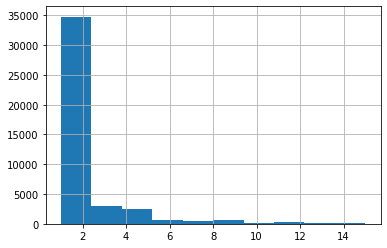

In [ ]:
masks['ships'] = masks['EncodedPixels'].map(lambda encoded_pixels: 1 if isinstance(encoded_pixels, str) else 0)

start_time = time.time()
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'})
unique_img_ids['RleMaskList'] = masks.groupby('ImageId')['EncodedPixels'].apply(list)
unique_img_ids = unique_img_ids.reset_index()
end_time = time.time() - start_time
print("unique_img_ids groupby took: {}".format(end_time))
unique_img_ids = unique_img_ids[unique_img_ids['ships'] > 0]
unique_img_ids['ships'].hist()
unique_img_ids.sample(3)

34044 training masks
8512 validation masks


<AxesSubplot:>

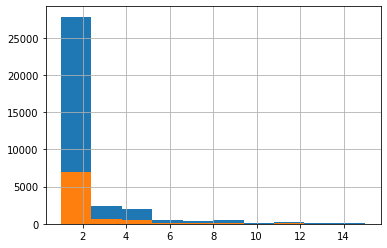

In [ ]:
from sklearn.model_selection import train_test_split
train_ids, val_ids = train_test_split(unique_img_ids, 
                 test_size = 0.2, 
                 stratify = unique_img_ids['ships'])
print(train_ids.shape[0], 'training masks')
print(val_ids.shape[0], 'validation masks')
train_ids['ships'].hist()
val_ids['ships'].hist()

Define a Dataset Class which holds the information related to the dataset as well as funcitons for loading it

In [ ]:
class ShipDetectionDataset(utils.Dataset):
    def __init__(self, image_dir, ids, masks, orig_height, orig_width):
        super().__init__(self)
        self.image_file_dir = image_dir
        self.ids = ids
        self.masks = masks
        self.image_width = orig_width
        self.image_height = orig_height

        self.add_class(SHIP_CLASS_NAME, 1, SHIP_CLASS_NAME)
        self.load_dataset()

    def load_dataset(self):
        for index, row in self.ids.iterrows():
            image_id = row['ImageId']
            image_path = os.path.join(self.image_file_dir, image_id)
            rle_mask_list = row['RleMaskList']
            self.add_image(
                SHIP_CLASS_NAME,
                image_id=image_id,
                path=image_path,
                width=self.image_width, height=self.image_height,
                rle_mask_list=rle_mask_list)

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        rle_mask_list = info['rle_mask_list']
        mask_count = len(rle_mask_list)
        mask = np.zeros([info['height'], info['width'], mask_count],
                        dtype=np.uint8)
        i = 0
        for rel in rle_mask_list:
            if isinstance(rel, str):
                np.copyto(mask[:,:,i], rle_decode(rel))
            i += 1
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info['source'] == SHIP_CLASS_NAME:
            return info['path']
        else:
            super(self.__class__, self).image_reference(image_id)

Define the configuration class for the model

In [ ]:
class ShipDetectionConfig(Config):
    NAME = 'SHIPS'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    BACKBONE = 'resnet50'
    
    IMAGE_RESIZE_MODE = "crop"

    NUM_CLASSES = 1+1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    STEPS_PER_EPOCH = 100
    VALIDATION_STEPS = 50
    SAVE_BEST_ONLY = True
    DETECTION_MIN_CONFIDENCE = 0.95
    DETECTION_NMS_THRESHOLD = 0.05
    TRAIN_ROIS_PER_IMAGE = 24
    LEARNING_RATE = 1e-4
    MAX_GT_INSTANCES = 14
    DETECTION_MAX_INSTANCES = 15

config = ShipDetectionConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.75
DETECTION_NMS_THRESHOLD        0.05
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE            

Prepare the datasets

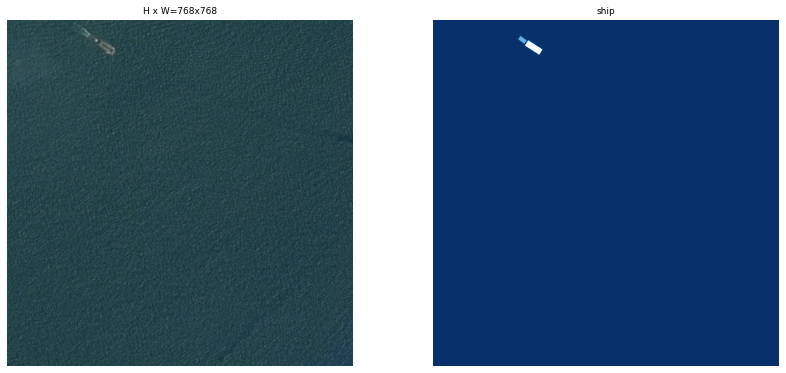

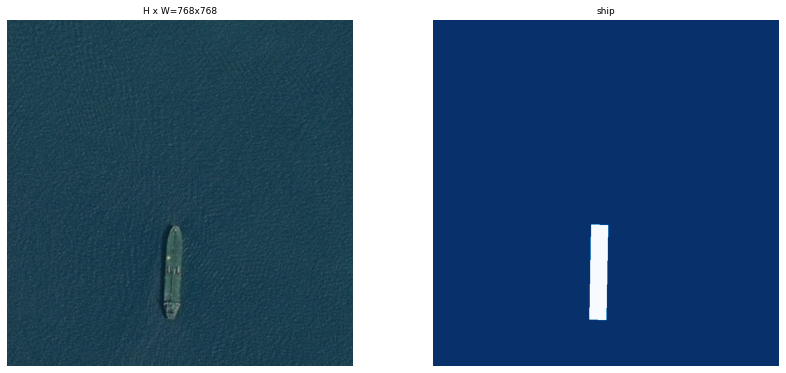

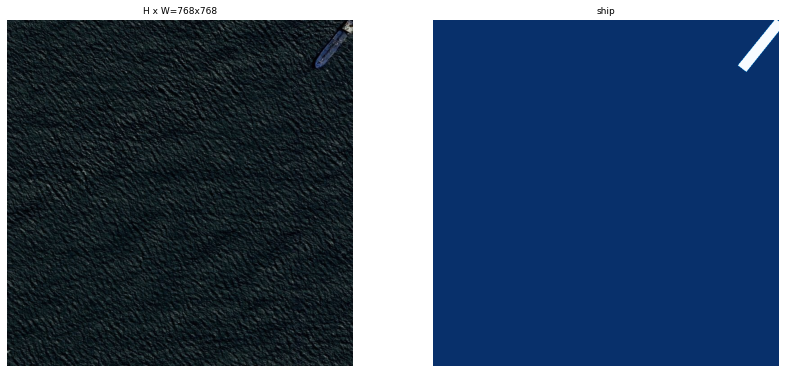

dataset prepare: 3.827382802963257


In [ ]:
start_time = time.time()
dataset_train = ShipDetectionDataset(image_dir=TRAIN_DATA_DIR, ids=train_ids, masks=masks, orig_height=768, orig_width=768)
dataset_train.prepare()
dataset_val = ShipDetectionDataset(image_dir=TRAIN_DATA_DIR, ids=val_ids, masks=masks, orig_height=768, orig_width=768)
dataset_val.prepare()

end_time = time.time() - start_time
print("dataset prepare: {}".format(end_time))

Define image augmentation procedures for use during training

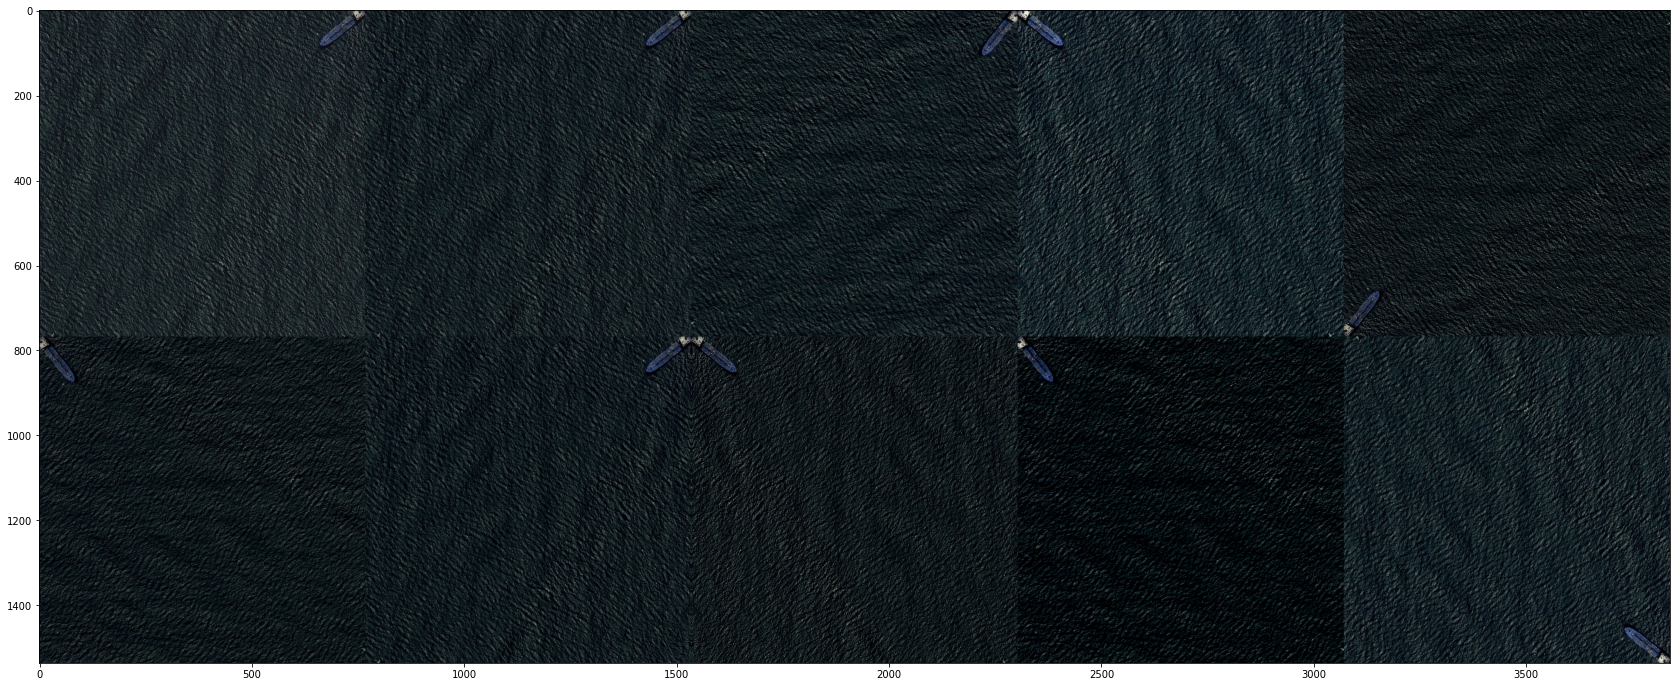

In [ ]:
# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## rotate
        iaa.Affine(rotate=0),
        iaa.Affine(rotate=90),
        iaa.Affine(rotate=180),
        iaa.Affine(rotate=270),
    ]),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.7, 1.4)),
        iaa.contrast.LinearContrast((0.7, 1.4)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.15)),
        iaa.Sharpen(alpha=(0.0, 0.15)),
    ]),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image, cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid.astype(int))


Initialise the model and load the weights from the COCO weights to give a better starting point for training

In [ ]:
model = modellib.MaskRCNN(mode="training", config=config, model_dir=ROOT_DIR)
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

Re-starting from epoch 60


Train the model

In [ ]:
start_time = time.time()    
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=80,
            layers='all',
            augmentation=augmentation)
end_time = time.time() - start_time
print("Train model: {}".format(end_time))


Starting at epoch 60. LR=1e-05

Checkpoint Path: /home/chris/Topics In Computer Science/Mask_RCNN/ships20201102T1440/mask_rcnn_ships_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
res2a_branch2a         (Conv2D)
res2a_branch2b         (Conv2D)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
res2b_branch2a         (Conv2D)
res2b_branch2b         (Conv2D)
res2b_branch2c         (Conv2D)
res2c_branch2a         (Conv2D)
res2c_branch2b         (Conv2D)
res2c_branch2c         (Conv2D)
res3a_branch2a         (Conv2D)
res3a_branch2b         (Conv2D)
res3a_branch2c         (Conv2D)
res3a_branch1          (Conv2D)
res3b_branch2a         (Conv2D)
res3b_branch2b         (Conv2D)
res3b_branch2c         (Conv2D)
res3c_branch2a         (Conv2D)
res3c_branch2b         (Conv2D)
res3c_branch2c         (Conv2D)
res3d_branch2a         (Conv2D)
res3d_branch2b         (Conv2D)
res3d_branch2c         (Conv2D)
res4a_branch2a         (Conv2D)
res4a_branch2b         (C

/home/chris/anaconda3/envs/mrcnn2/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


100/100 [==============================] - 52s 524ms/step - loss: 1.7410 - rpn_class_loss: 0.2184 - rpn_bbox_loss: 0.8448 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.3350 - mrcnn_mask_loss: 0.3302 - val_loss: 1.3987 - val_rpn_class_loss: 0.1020 - val_rpn_bbox_loss: 0.6661 - val_mrcnn_class_loss: 0.0191 - val_mrcnn_bbox_loss: 0.2965 - val_mrcnn_mask_loss: 0.3150
Epoch 62/80
100/100 [==============================] - 50s 496ms/step - loss: 2.2604 - rpn_class_loss: 0.3597 - rpn_bbox_loss: 1.1068 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.4342 - mrcnn_mask_loss: 0.3285 - val_loss: 1.2970 - val_rpn_class_loss: 0.1152 - val_rpn_bbox_loss: 0.5719 - val_mrcnn_class_loss: 0.0187 - val_mrcnn_bbox_loss: 0.2799 - val_mrcnn_mask_loss: 0.3112
Epoch 63/80
100/100 [==============================] - 52s 522ms/step - loss: 1.6359 - rpn_class_loss: 0.0987 - rpn_bbox_loss: 0.8550 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.3589 - mrcnn_mask_loss: 0.2606 - val_loss: 1.2883 - val_rpn_class_loss

In [ ]:
history = model.keras_model.history.history

Display results for loss functions after training.

In [ ]:
epochs = range(1, len(history['loss'])+1)
pd.DataFrame(history, index=epochs)

loss  rpn_class_loss  rpn_bbox_loss  mrcnn_class_loss  \
1   1.740984        0.218396       0.844814          0.012630   
2   2.260432        0.359739       1.106816          0.031218   
3   1.635942        0.098701       0.855032          0.062672   
4   1.551373        0.194696       0.800841          0.017907   
5   1.485200        0.118370       0.690809          0.058260   
6   1.912086        0.154901       1.373029          0.011906   
7   2.145209        0.103957       1.233570          0.080925   
8   2.106454        0.145145       1.194971          0.038280   
9   1.972493        0.353732       1.214226          0.024069   
10  1.522437        0.212415       0.531283          0.030309   
11  1.929021        0.052451       1.158161          0.022973   
12  1.639383        0.132853       1.067778          0.013820   
13  2.164710        0.221013       1.103842          0.045278   
14  1.584243        0.204016       1.041179          0.014128   
15  1.660792        0.154141       0.835174          0.047001   
16  1.809080        0.143162       0.794861          0.086746   
17  2.409325        0.188025       1.601755          0.073662   
18  2.542655        0.262928       1.703825          0.020116   
19  2.162592        0.114743       1.093498          0.032205   
20  2.495942        0.187242       1.499305          0.022842   

    mrcnn_bbox_loss  mrcnn_mask_loss  val_loss  val_rpn_class_loss  \
1          0.334966         0.330177  1.398670            0.101987   
2          0.434156         0.328504  1.296955            0.115240   
3          0.358928         0.260609  1.288268            0.127017   
4          0.267791         0.270138  1.383545            0.103243   
5          0.307783         0.309978  1.452562            0.101531   
6          0.154117         0.218132  1.525355            0.090305   
7          0.362192         0.364566  1.388118            0.101046   
8          0.380571         0.347486  1.359974            0.105111   
9          0.175148         0.205319  1.363634            0.104234   
10         0.352383         0.396047  1.318533            0.114655   
11         0.367695         0.327741  1.321702            0.107715   
12         0.220620         0.204312  1.285814            0.101981   
13         0.356440         0.438136  1.348548            0.101231   
14         0.143587         0.181332  1.371241            0.092069   
15         0.324215         0.300261  1.364579            0.099016   
16         0.398083         0.386227  1.353521            0.096932   
17         0.297568         0.248314  1.370802            0.097456   
18         0.263193         0.292593  1.405494            0.092508   
19         0.453195         0.468951  1.368309            0.091984   
20         0.411570         0.374982  1.295619            0.099334   

    val_rpn_bbox_loss  val_mrcnn_class_loss  val_mrcnn_bbox_loss  \
1            0.666050              0.019071             0.296546   
2            0.571858              0.018734             0.279898   
3            0.552554              0.018467             0.284055   
4            0.632397              0.017584             0.295857   
5            0.679992              0.016188             0.318451   
6            0.748189              0.018686             0.330409   
7            0.597612              0.022336             0.339557   
8            0.580855              0.018956             0.331524   
9            0.596220              0.018391             0.320503   
10           0.527534              0.022840             0.328421   
11           0.558107              0.022462             0.314055   
12           0.544793              0.021097             0.297183   
13           0.593005              0.017148             0.321553   
14           0.606284              0.019256             0.325710   
15           0.568469              0.024739             0.342703   
16           0.563091              0.020365             0.342750   
17           0.

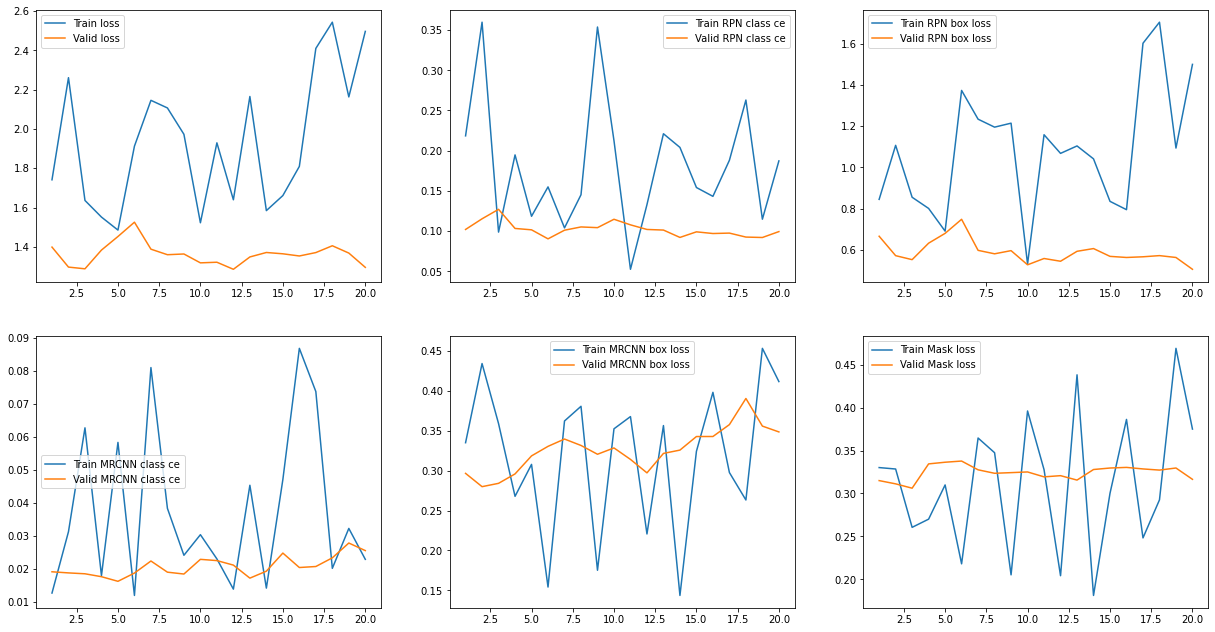

In [ ]:


plt.figure(figsize=(21,11))

plt.subplot(231)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(232)
plt.plot(epochs, history["rpn_class_loss"], label="Train RPN class ce")
plt.plot(epochs, history["val_rpn_class_loss"], label="Valid RPN class ce")
plt.legend()
plt.subplot(233)
plt.plot(epochs, history["rpn_bbox_loss"], label="Train RPN box loss")
plt.plot(epochs, history["val_rpn_bbox_loss"], label="Valid RPN box loss")
plt.legend()
plt.subplot(234)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train MRCNN class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid MRCNN class ce")
plt.legend()
plt.subplot(235)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train MRCNN box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid MRCNN box loss")
plt.legend()
plt.subplot(236)
plt.plot(epochs, history["mrcnn_mask_loss"], label="Train Mask loss")
plt.plot(epochs, history["val_mrcnn_mask_loss"], label="Valid Mask loss")
plt.legend()

plt.show()



In [ ]:
best_epoch = np.argmin(history["val_loss"])
score = history["val_loss"][best_epoch]
print(f'Best Epoch:{best_epoch+1} val_loss:{score}')

Best Epoch:12 val_loss:1.285814356803894
